In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import plot_utils

In [2]:
methods = {
    # 'n_3r1i': '3 dims\n1 answer',
    # 'n_1r1i': '1 dim\n1 answer',
    'n_1r10i': '1 dim\n10 answers',
    'n_1r20i': '1 dim\n20 answers',
    'n_1r50i': '1 dim\n50 answers',
    's_1r20i': '1 dim\n20 answers\n10 samples',
    'n_1r20i_numeric': '1 dim\n20 answers\nrating-only',
    's_1r20i_numeric': '1 dim\n20 answers\nrating-only\n10 samples',
}

In [3]:
measures = ('novelty', 'feasibility', 'value')

In [4]:
models = {
    'GPT-4': '',
    'GPT-4-turbo': '-turbo',
    'GPT-4o': '-omni',
    'Claude 3.5 Sonnet': '-sonnet'
}

In [5]:
squid = []
rmsd = []
for model, suffix in models.items():
    for method, name in methods.items():
        data = pd.read_excel(f'gpt-ratings/{method}{suffix}.xlsx')
        for qid in data['Question id'].unique():
            qmask = data['Question id'] == qid
            entry = {'method': name, 'model': model}
            rmsd_entry = {'method': name, 'model': model}
            for key in measures:
                mask = qmask
                if key == 'value':
                    mask &= (data[key]>0) & (data[key]<100_000)

                entry[key] = stats.spearmanr(data[mask][[key.capitalize(), key]]).statistic

                x = data[mask][key.capitalize()]
                x_rank = np.empty(x.shape, int)
                x_rank[np.argsort(x)] = np.arange(len(x))

                y = data[mask][key]
                y_rank = np.empty(y.shape, int)
                y_rank[np.argsort(y)] = np.arange(len(y))

                rmsd_entry[key] = np.sqrt(np.mean(np.square(y_rank - x_rank)))

            squid.append(entry)
            rmsd.append(rmsd_entry)
spearman_qid = pd.DataFrame(squid).fillna(0)
rmsd = pd.DataFrame(rmsd).fillna(0)

/home/felix/projects/elo-gpt/.env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/felix/projects/elo-gpt/.env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, '')

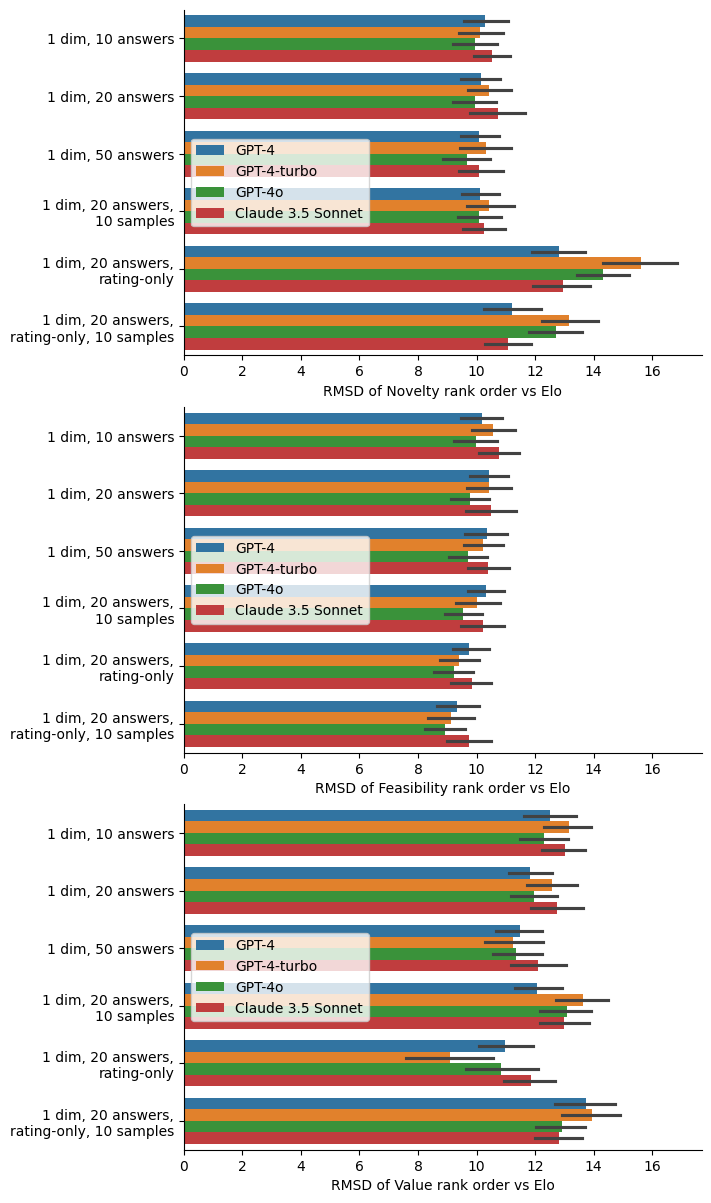

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(7,12), layout='compressed')
xmax = 0
for ax, measure in zip(axs, measures):
    long = rmsd.set_index('method').loc[:, ['model', measure]]
    long.index = [s.replace('\n',', ').replace('answers, ','answers,\n') for s in long.index]
    sns.barplot(long, y=long.index, x=measure, hue='model', ax=ax)
    ax.legend(ax.containers, models.keys(), loc='center left')
    ax.set_ylabel('')
    ax.set_xlabel(f'RMSD of {measure.capitalize()} rank order vs Elo')
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs:
    ax.set_xlim(0, xmax)
sns.despine()
fig.suptitle('')

In [23]:
mean = spearman_qid.groupby(['method', 'model']).mean()

In [24]:
std = spearman_qid.groupby(['method', 'model']).std()

In [46]:
print('Mean of Spearman-by-question')
print('Method\t', '\t\t\t\t'.join([m.capitalize() for m in measures]))
print('Model\t', *['\t'.join(models.keys()) + '\t' for m in measures])
for method in methods.values():
    m = method.replace('\n', ', ')
    print(m, end='')
    for measure in measures:
        for model in models.keys():
            mean_ = mean.loc[method, model][measure]
            print(f'\t{mean_:.2f}', end='')
    print()

Mean of Spearman-by-question
Method	 Novelty				Feasibility				Value
Model	 GPT-4	GPT-4-turbo	GPT-4o	Claude 3.5 Sonnet	 GPT-4	GPT-4-turbo	GPT-4o	Claude 3.5 Sonnet	 GPT-4	GPT-4-turbo	GPT-4o	Claude 3.5 Sonnet	
1 dim, 10 answers	0.61	0.62	0.64	0.59	0.62	0.59	0.63	0.57	0.33	0.26	0.37	0.36
1 dim, 20 answers	0.64	0.60	0.64	0.58	0.60	0.59	0.66	0.59	0.36	0.26	0.38	0.36
1 dim, 50 answers	0.65	0.61	0.66	0.62	0.62	0.61	0.67	0.60	0.43	0.30	0.47	0.43
1 dim, 20 answers, 10 samples	0.63	0.60	0.63	0.61	0.62	0.63	0.67	0.61	0.39	0.21	0.33	0.37
1 dim, 20 answers, rating-only	0.38	0.07	0.24	0.37	0.65	0.67	0.69	0.64	0.39	0.24	0.25	0.45
1 dim, 20 answers, rating-only, 10 samples	0.52	0.34	0.40	0.54	0.68	0.69	0.71	0.65	0.31	0.29	0.39	0.40


In [47]:
print('s.d. of Spearman-by-question')
print('Method\t', '\t\t\t\t'.join([m.capitalize() for m in measures]))
print('Model\t', *['\t'.join(models.keys()) + '\t' for m in measures])
for method in methods.values():
    m = method.replace('\n', ', ')
    print(m, end='')
    for measure in measures:
        for model in models.keys():
            sd_ = std.loc[method, model][measure]
            print(f'\t{sd_:.2f}', end='')
    print()

s.d. of Spearman-by-question
Method	 Novelty				Feasibility				Value
Model	 GPT-4	GPT-4-turbo	GPT-4o	Claude 3.5 Sonnet	 GPT-4	GPT-4-turbo	GPT-4o	Claude 3.5 Sonnet	 GPT-4	GPT-4-turbo	GPT-4o	Claude 3.5 Sonnet	
1 dim, 10 answers	0.12	0.13	0.10	0.11	0.14	0.14	0.12	0.13	0.18	0.18	0.16	0.14
1 dim, 20 answers	0.10	0.15	0.12	0.16	0.14	0.15	0.10	0.16	0.16	0.18	0.17	0.18
1 dim, 50 answers	0.11	0.14	0.12	0.15	0.13	0.16	0.10	0.13	0.14	0.20	0.18	0.17
1 dim, 20 answers, 10 samples	0.12	0.14	0.12	0.13	0.11	0.13	0.10	0.15	0.13	0.22	0.19	0.18
1 dim, 20 answers, rating-only	0.25	0.39	0.23	0.25	0.12	0.11	0.11	0.11	0.17	0.26	0.21	0.16
1 dim, 20 answers, rating-only, 10 samples	0.25	0.28	0.22	0.19	0.13	0.12	0.13	0.14	0.22	0.19	0.17	0.16


In [48]:
print('SNR of Spearman-by-question')
print('Method\t', '\t\t\t\t'.join([m.capitalize() for m in measures]))
print('Model\t', *['\t'.join(models.keys()) + '\t' for m in measures])
for method in methods.values():
    m = method.replace('\n', ', ')
    print(m, end='')
    for measure in measures:
        for model in models.keys():
            mean_ = mean.loc[method, model][measure]
            sd_ = std.loc[method, model][measure]
            print(f'\t{mean_/sd_:.2f}', end='')
    print()

SNR of Spearman-by-question
Method	 Novelty				Feasibility				Value
Model	 GPT-4	GPT-4-turbo	GPT-4o	Claude 3.5 Sonnet	 GPT-4	GPT-4-turbo	GPT-4o	Claude 3.5 Sonnet	 GPT-4	GPT-4-turbo	GPT-4o	Claude 3.5 Sonnet	
1 dim, 10 answers	5.03	4.95	6.24	5.54	4.30	4.15	5.12	4.41	1.83	1.41	2.30	2.46
1 dim, 20 answers	6.24	4.10	5.24	3.71	4.41	3.83	6.28	3.58	2.29	1.48	2.21	2.00
1 dim, 50 answers	5.80	4.32	5.48	4.26	4.83	3.87	7.05	4.61	3.05	1.51	2.54	2.44
1 dim, 20 answers, 10 samples	5.17	4.32	5.32	4.56	5.58	4.77	6.62	4.08	2.95	0.92	1.71	2.06
1 dim, 20 answers, rating-only	1.53	0.17	1.04	1.48	5.32	5.89	6.38	5.79	2.26	0.89	1.19	2.81
1 dim, 20 answers, rating-only, 10 samples	2.04	1.25	1.85	2.85	5.29	5.58	5.51	4.75	1.40	1.49	2.37	2.52
